<div Style="text-align: center;line-height: 30px;font-size:32px;font-weight: bold"> Clasificador de fitolitos</div>
***

Este *notebook* esta basado en otro *notebook* cuyo autor es el Dr. José Francisco Diez (UBU). En este no se explican los detalles sobre las tareas de clasificación, *Bag of Words*, descriptores características, etc. Para ello revise la documentación en este mismo repositorio.

In [1]:
%matplotlib inline 
#para dibujar en el propio notebook
import numpy as np  #numpy como np
import matplotlib.pyplot as plt #matplotlib como plot

from skimage.feature import daisy
from skimage.color import rgb2gray

from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn import svm

import warnings

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

### Cargamos imágenes y las covertimos a escala de grises

In [2]:
from ImageDataset import ImageDataset

# phytoliths_types = ['Rondel','Bulliform','Bilobate','Trichomas',
#  'Saddle', 'Spherical', 'Cyperaceae']

phytoliths_types = ['Phytolith', 'Background']

dataset=ImageDataset('../../rsc/img', phytoliths_types)

In [3]:
X,y = dataset.getData()
X = list(map(rgb2gray,X))

#### Ejemplo de fitolito en escala de grises

Background


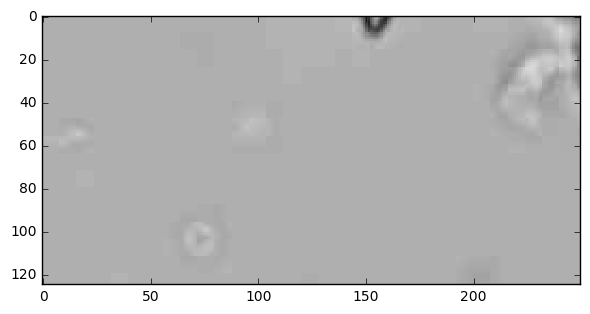

In [4]:
from skimage.io import imshow

imshow(X[25])
print(y[25])

### Dividimos el conjunto de imágenes para el entrenamiento y evaluación

In [5]:
TRAIN_SIZE = 0.7

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size = TRAIN_SIZE)

### Extraemos las características de las imágenes del conjunto de entrenamiento

Mediante la técnica de Bag of Words.

In [7]:
def features_extractor(img, descriptor = daisy):
    features = descriptor(img)
    numFils, numCols, sizeDesc = features.shape
    features = features.reshape((numFils*numCols,sizeDesc))
    return features

In [8]:
PROGRESS_NOTIFICATION = 10
def whole_features_extractor(X_train):
    '''Método encargado de extraer las 
    características de un conjunto de 
    imágenes'''
    train_features = []
    i = 0
    
    for img in X_train: 
        if i%PROGRESS_NOTIFICATION ==0:
            print("Procesada imagen"+str(i)+"/"+
                  str(len(X_train)), end="\r")
        
        train_features.append(features_extractor(img))
        i += 1
    print("Procesadas todas las imágenes", end="\r")
    
    all_features = np.concatenate(train_features)
    
    return train_features, all_features
    

In [9]:
NUM_CENTERS = 200

In [10]:
def get_features_cluster(X_train, num_centers):
    
    train_features, all_features = whole_features_extractor(X_train)
    # Se inicializa el algoritmo de Kmeans 
    # indicando el número de clusters
    warnings.filterwarnings("ignore")
    kmeans = KMeans(num_centers)
    
    # Se construye el cluster con todas las 
    # características del conjunto de entramiento
    return kmeans.fit(all_features),train_features
    
cluster, train_features = get_features_cluster(X_train, NUM_CENTERS)

### Obtenemos el conjunto de entrenamiento

In [11]:
def bow_histogram_extractor(imgFeatures, num_centers):
    # extrae pertenencias a cluster
    pertenencias=cluster.predict(imgFeatures)
    # extrae histograma
    bow_representation, _ = np.histogram(pertenencias, 
                                         bins=num_centers, 
                                         range=(0,num_centers-1))
    return bow_representation

In [12]:
# Si le paso un conjunto de imagenes X saca las caracteristicas
# Si le paso las features usa directamente las features
def get_training_set(cluster,X=None, t_features=None):
    
    train_features = t_features
    
    if t_features is None:
        train_features, _ = whole_features_extractor(X)
    
    
    num_centers = len(cluster.cluster_centers_)
    trainInstances = []
    
    for imgFeatures in train_features:
        # añade al conjunto de entrenamiento final
        trainInstances.append(bow_histogram_extractor(imgFeatures,
                                                      num_centers))
    
    trainInstances = np.array(trainInstances)
    return trainInstances

In [13]:
trainInstances = get_training_set(cluster,X=X_train)

### Obtenemos clasificador

In [14]:
def get_trained_classifier(trainInstances,y_train, 
                           classifier= svm.SVC(kernel='linear',
                                               C=0.01,
                                               probability=True)):
    return classifier.fit(trainInstances, y_train)

In [15]:
cls = get_trained_classifier(trainInstances,y_train, AdaBoostClassifier(learning_rate=1.5,
                                                                       base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                                                                                                             max_features=None, max_leaf_nodes=None,
                                                                                                             min_impurity_split=1e-07, min_samples_leaf=1,
                                                                                                             min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                                                                             presort=False, random_state=None, splitter='best'),
                                                                       algorithm='SAMME.R', n_estimators=600))

### Predecimos imágenes

Mediante la técnica de Bag of Words.

In [16]:
def predict_image(imgTest):
    global cluster
    global cls
    
    num_centers = len(cluster.cluster_centers_)
    imgFeatures = features_extractor(imgTest)
    
    testInstances = np.array(bow_histogram_extractor(imgFeatures,
                                                     num_centers))
    
    return cls.predict_proba(testInstances)

In [17]:
def predict_image_class(imgTest, types = dataset.getClasses()):
    return types[np.argmax(predict_image(imgTest)[0])]

In [18]:
predict_image_class(X_test[30])

'Background'

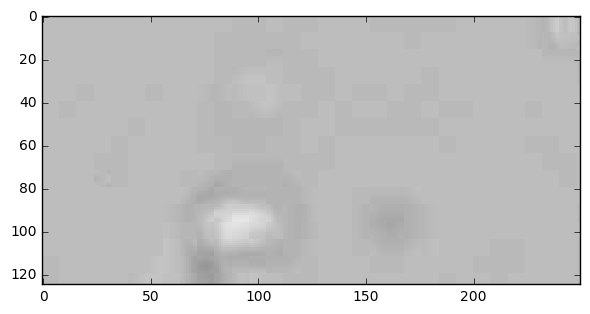

In [19]:
imshow(X_test[30])

### Evaluamos la precisión del clasificador

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
testInstances = get_training_set(cluster,X=X_test)

In [22]:
y_pred = list(map(predict_image_class,X_test))

In [23]:
print("%.2f" % accuracy_score(y_test, y_pred))

0.98
